## Test file for Stat Quests 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoTokenizer
from datasets import load_dataset
from scipy import stats

In [7]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Get the vocabulary (it's a dict of token: id)
vocab = tokenizer.get_vocab()
vocab_size = tokenizer.vocab_size

# Convert to a DataFrame for easier manipulation
vocab_df = pd.DataFrame(vocab.items(), columns=['token', 'id'])
vocab_df = vocab_df.set_index('id').sort_index()

print(f"Loaded vocabulary with {vocab_size} tokens.")
print(vocab_df.head())

c:\Users\Vatsal\OneDrive\Desktop\Yipeee\venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vatsal\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loaded vocabulary with 50257 tokens.
   token
id      
0      !
1      "
2      #
3      $
4      %


Generating train split: 500 examples [00:00, 16554.85 examples/s]
Map: 100%|██████████| 500/500 [00:00<00:00, 8630.01 examples/s]


         token  frequency
id                       
66           c        155
62           _         81
4499  Ġlearned         80
73           j         80
411        res         75


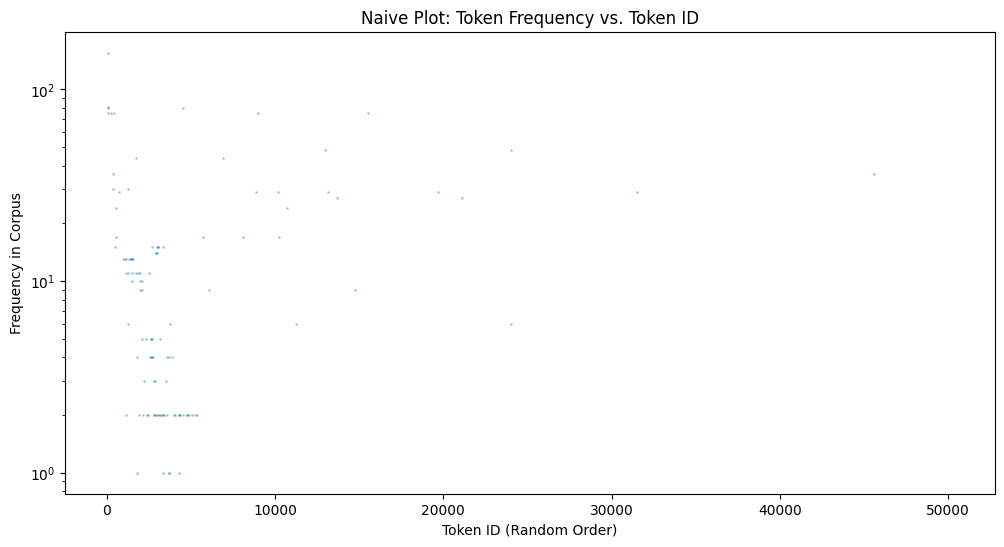

In [9]:
# Load the dataset (Brown Corpus)
# The Brown dataset uses the 'default' config (or no config). 'main' is not available.
dataset = load_dataset("brown", split="train")

# Initialize a counter for all token IDs
total_token_counts = Counter()

# Process the dataset in chunks (good practice, essential for large sets)
def update_counts(batch):
    # Tokenize the text and get the input_ids
    tokenized_inputs = tokenizer(batch["text"], truncation=False)
    # Flatten the list of lists and update the counter
    for ids in tokenized_inputs["input_ids"]:
        total_token_counts.update(ids)
    # Return the batch unchanged so .map() works without errors
    return batch

# .map() is an efficient way to apply our function
dataset.map(update_counts, batched=True, batch_size=1000)

# Map the counts back to our vocabulary DataFrame
vocab_df['frequency'] = vocab_df.index.map(total_token_counts).fillna(0).astype(int)

print(vocab_df.sort_values('frequency', ascending=False).head())

# --- Plot 1: Naive Order (Frequency vs. Token ID) ---
plt.figure(figsize=(12, 6))
plt.scatter(vocab_df.index, vocab_df['frequency'], s=1, alpha=0.3)
plt.title("Naive Plot: Token Frequency vs. Token ID")
plt.xlabel("Token ID (Random Order)")
plt.ylabel("Frequency in Corpus")
plt.yscale('log') # Use a log scale, otherwise you'll just see a few dots
plt.show()

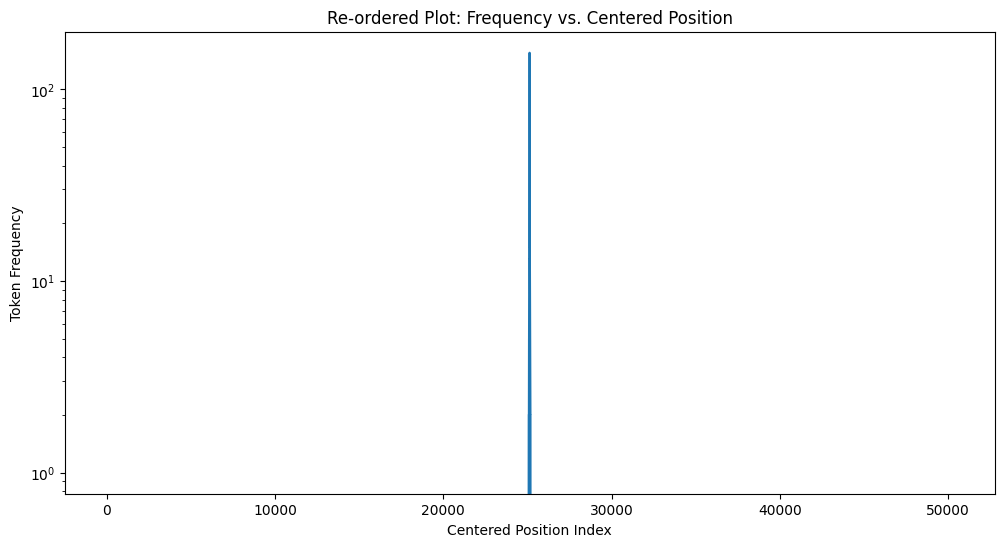

In [10]:
# 1. Sort the DataFrame by frequency, highest first
df_sorted = vocab_df.sort_values('frequency', ascending=False)
sorted_frequencies = df_sorted['frequency'].values

# 2. Create a new array to hold the centered plot data
plot_data = np.zeros(vocab_size)
center_index = int(vocab_size / 2)

# 3. Assign frequencies, starting from the center and moving outwards
plot_data[center_index] = sorted_frequencies[0] # Most frequent token at the center
offset = 1
for i in range(1, vocab_size, 2):
    # Place next token on the right
    if center_index + offset < vocab_size:
        plot_data[center_index + offset] = sorted_frequencies[i]
    
    # Place next token on the left
    if i + 1 < vocab_size and center_index - offset >= 0:
        plot_data[center_index - offset] = sorted_frequencies[i+1]
    
    offset += 1

# --- Plot 2: Centered "Bell" Curve ---
plt.figure(figsize=(12, 6))
plt.plot(plot_data)
plt.title("Re-ordered Plot: Frequency vs. Centered Position")
plt.xlabel("Centered Position Index")
plt.ylabel("Token Frequency")
plt.yscale('log') # Log scale is still recommended
plt.show()

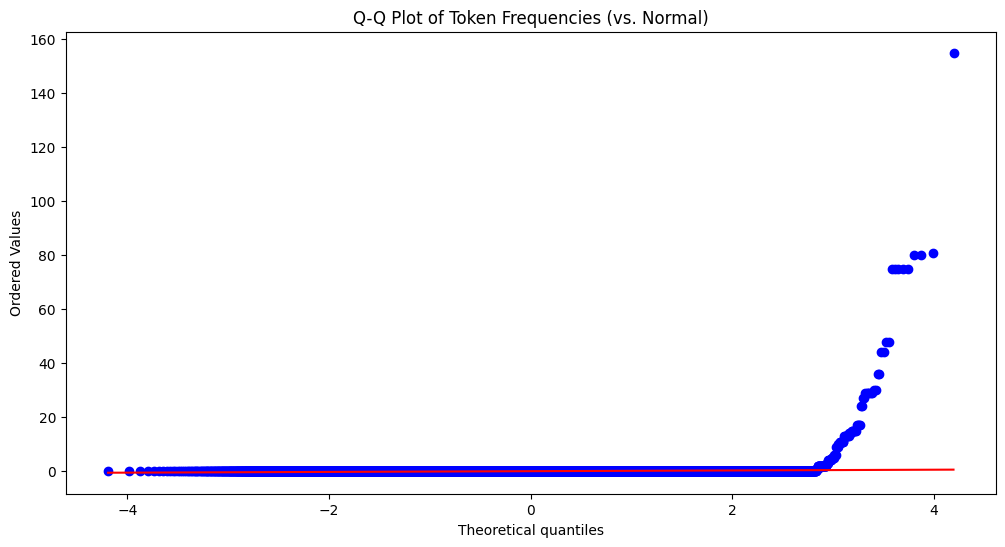

c:\Users\Vatsal\OneDrive\Desktop\Yipeee\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50257.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for Raw Frequencies: Stat=0.0096, p-value=1.2757432678760093e-163
Shapiro-Wilk Test for Log-Frequencies: Stat=0.0200, p-value=2.837404112271793e-163


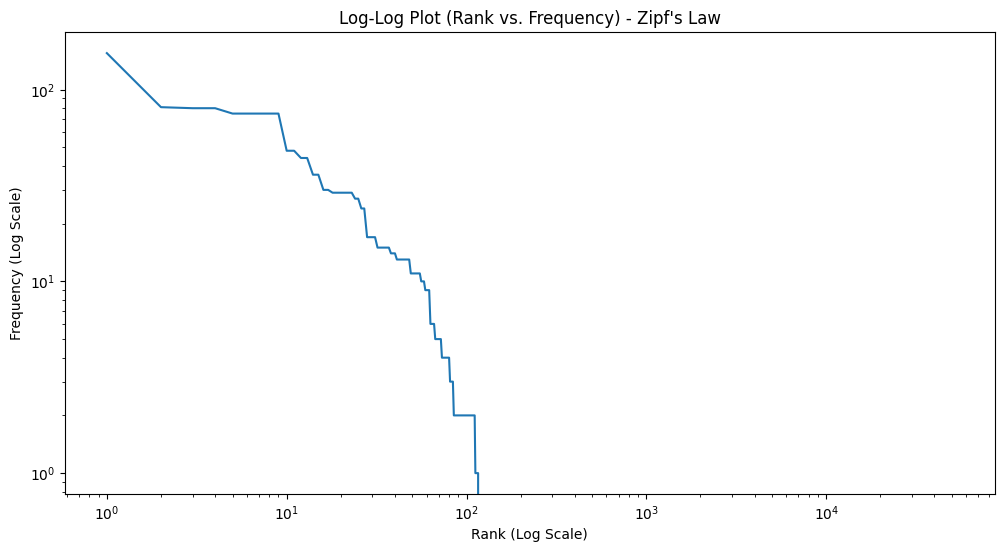

In [11]:
# We test the *distribution of the frequency values*, not the plot
# We add 1 before logging to avoid log(0)
frequency_values = vocab_df['frequency'].values
log_frequency_values = np.log(frequency_values + 1)

# --- Test 1: Q-Q Plot ---
plt.figure(figsize=(12, 6))
stats.probplot(frequency_values, dist="norm", plot=plt)
plt.title("Q-Q Plot of Token Frequencies (vs. Normal)")
plt.show()
# A normal distribution would follow the red line. This will not.

# --- Test 2: Shapiro-Wilk Test ---
# Note: Shapiro-Wilk is less reliable for >5000 samples, but we'll run it.
# A p-value < 0.05 means we REJECT the hypothesis that it's normal.
stat, p_value = stats.shapiro(frequency_values)
print(f"Shapiro-Wilk Test for Raw Frequencies: Stat={stat:.4f}, p-value={p_value}")

# It's often better to test the log-transformed data
stat_log, p_log = stats.shapiro(log_frequency_values)
print(f"Shapiro-Wilk Test for Log-Frequencies: Stat={stat_log:.4f}, p-value={p_log}")

# --- Bonus: The "Correct" Plot (Log-Log) ---
# This is how you traditionally visualize a Zipfian distribution.
# It should look like a straight line.
rank = np.arange(1, vocab_size + 1)
frequency_sorted = vocab_df['frequency'].sort_values(ascending=False).values

plt.figure(figsize=(12, 6))
plt.loglog(rank, frequency_sorted)
plt.title("Log-Log Plot (Rank vs. Frequency) - Zipf's Law")
plt.xlabel("Rank (Log Scale)")
plt.ylabel("Frequency (Log Scale)")
plt.show()